## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.models import UtilityParameters, BPRParameters, ODParameters, GISUELOGIT, NGD, compute_rr
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates, plot_top_od_flows_periods, plot_utility_parameters_periods
from src.gisuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.gisuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split, add_period_id, get_tensors_by_year
from src.gisuelogit.descriptive_statistics import mse, btcg_mse, mnrmse, nrmse

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build Fresno network

In [5]:
fresno_network = build_fresno_network()

## Read OD matrix

In [6]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


## Read paths

In [7]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
#read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

442.3 trips were loaded among 70 o-d pairs
Generating at most 2 paths per od
140 paths were generated among 70 od pairs in 1.1 [s]

140 paths were loaded in the network
Matrix D (2413, 140) generated in 0.1[s]               

Matrix M (70, 140) generated in 0.0[s]               

Matrix C (140, 140) generated in 0.0[s]               



## Read spatiotemporal data

In [8]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday to Thursday
df = df[df['date'].dt.dayofweek.between(1, 3)]
# df = df[df['date'].dt.year == 2019]

In [9]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [10]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period,period_id
0,"(0, 1621, '0')",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10,4
1,"(1239, 1630, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
2,"(228, 192, '0')",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10,4
3,"(1243, 1631, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
4,"(1244, 1632, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4


In [11]:
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

,speed_ref_avg,speed_hist_avg,speed_max
count,1.013460e+06,1.009583e+06,1.013460e+06
mean,1.924470e+01,1.767589e+01,2.051278e+01
std,1.982261e+01,1.909664e+01,2.140424e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.112700e+01,1.755400e+01,2.112700e+01
75%,2.796200e+01,2.547600e+01,3.106900e+01
max,6.772900e+01,7.891400e+01,8.388500e+01


In [12]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [13]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg,tt_sd_adj
count,1.013460e+06,1.009583e+06,1.013460e+06,887813.000000,1.013460e+06
mean,1.924470e+01,1.767589e+01,3.397371e-03,0.003658,3.022799e-04
std,1.982261e+01,1.909664e+01,4.350074e-03,0.004367,4.638521e-04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,2.112700e+01,1.755400e+01,2.495627e-03,0.002784,1.856268e-04
75%,2.796200e+01,2.547600e+01,4.653995e-03,0.005216,4.248116e-04
max,6.772900e+01,7.891400e+01,7.034335e-02,0.063791,1.243267e-02


## Utility function

In [14]:
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
# features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']


utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [15]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [16]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.003415,0.003699,0.200169,0.000302
std,770.228931,0.004370,0.004448,0.228208,0.000464
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.002508,0.002814,0.152000,0.000186
75%,2162.450000,0.004702,0.005304,0.280000,0.000425
max,4807.000000,0.070343,0.063791,2.302000,0.012433


In [17]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.003377,0.003613,0.198494,0.000302
std,743.713869,0.004326,0.004275,0.226003,0.000464
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.002491,0.002756,0.150000,0.000186
75%,1978.000000,0.004578,0.005112,0.273000,0.000425
max,4766.000000,0.070343,0.054574,2.113000,0.012433


In [18]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

In [19]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

,counts,tt_avg
counts,1.000000,0.055122
tt_avg,0.055122,1.000000


## EDA

In [20]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [21]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Link attributes

In [22]:
df[features_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,3.022799e-04,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,4.638521e-04,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.856268e-04,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.248116e-04,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,1.243267e-02,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [23]:
# Include only data between 4pm and 5pm
# X, Y = get_tensors_by_year(df, features_Z = features_Z, network = fresno_network)
#X, Y = get_tensors_by_year(df[df.hour == 16], features_Z = features_Z, network = fresno_network)
#X, Y = get_tensors_by_year(df[df.hour.isin(range(15,16))], features_Z = features_Z, network = fresno_network)
X, Y = get_tensors_by_year(df[df.hour.isin([16,17,18,19])], features_Z = features_Z, network = fresno_network)

# Include hourly data between 6AM and 8PM (15 hour intervals)
# XT, YT = get_tensors_by_year(df, features_Z = features_Z)
#XT, YT = get_tensors_by_year(df[df.hour.isin(range(15,16))], features_Z = features_Z, network = fresno_network)
XT, YT = get_tensors_by_year(df[df.hour.isin([16,17,18,19])], features_Z = features_Z, network = fresno_network)


# X_train, X_test, Y_train, Y_test = temporal_split(X[2019].numpy(), Y[2019].numpy(), n_days = X[2019].shape[0])

# X_train, X_test, Y_train, Y_test = X[2020], X[2019], Y[2020], Y[2019]
X_train, X_test, Y_train, Y_test = X[2019], X[2020], Y[2019], Y[2020]
XT_train, XT_test, YT_train, YT_test = XT[2019], XT[2020], YT[2019], YT[2020]

# Remove validation set to reduce computation costs
X_test, Y_test = None, None
XT_test, YT_test = None, None

2022-11-25 19:30:24.827876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Network equilibrium predictor

In [24]:
equilibrator = Equilibrator(
    network=fresno_network,
    # paths_generator=paths_generator,
    utility=utility_parameters,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

column_generator = ColumnGenerator(equilibrator=equilibrator,
                                   utility=utility_parameters,
                                   n_paths=0,
                                   ods_coverage=0.1,
                                   ods_sampling='sequential',
                                   # ods_sampling='demand',
                                   )

## Configuration

In [30]:
_EPOCHS = {'learning': 6, 'equilibrium': 10}
#_EPOCHS = {'learning': 200, 'equilibrium': 20}
_BATCH_SIZE = 16
_LR = 5e-1
_RELATIVE_GAP = 1e-10
_XTICKS_SPACING = 50
_EPOCHS_PRINT_INTERVAL = 1

# When adding fixed effects, all parameters of the utility function are idenfiable but provided that the utility coefficients are period specific. The
# only attribute that is always identifiable is the standard deviation of travel time because it changes over hours for same link. Overall, removing fixed effect ease the identification of the parameters of the utility function.
_FIXED_EFFECT = False
# features_Z = ['tt_sd']

# Excluding historic OD gives more freedom for the model to find an equilibria and minimize reconstruction error
_LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}

# _LOSS_METRIC  = mnrmse
# _MOMENTUM_EQUILIBRIUM = {'lue': 0.95, 'odlue': 0.95, 'odlulpe': 0.95, 'tvodlulpe':0.95}

# NRMSE encourages a larger reduction in link flow loss and it does not requires to add much momentum to the equilibrium loss component
_LOSS_METRIC  = nrmse
_MOMENTUM_EQUILIBRIUM = {'lue': 0.99, 'odlue': 0.99, 'odlulpe': 0.99, 'tvodlulpe':0.99}
#_MOMENTUM_EQUILIBRIUM = {'lue': 0.95, 'odlue': 0.95, 'odlulpe': 0.95, 'tvodlulpe':0.95}

# Including historic OD matrix
# _LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1}
# _MOMENTUM_EQUILIBRIUM = 0.99

# _LOSS_METRIC = mse
# _LOSS_WEIGHTS ={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1}

print(f"_LOSS_WEIGHTS: {_LOSS_WEIGHTS}, _MOMENTUM_EQUILIBRIUM: {_MOMENTUM_EQUILIBRIUM}, "
      f"epochs { _EPOCHS}")

_LOSS_WEIGHTS: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}, _MOMENTUM_EQUILIBRIUM: {'lue': 0.99, 'odlue': 0.99, 'odlulpe': 0.99, 'tvodlulpe': 0.99}, epochs {'learning': 6, 'equilibrium': 10}


## Models

In [26]:
run_model = dict.fromkeys(['lue', 'odlue','odlulpe', 'tvodlulpe'], True)

# run_model['lue'] = True
# run_model['odlue'] = True
# run_model['odlulpe'] = True
# run_model['tvodlulpe'] = True

In [27]:
train_results_dfs = {}
test_results_dfs = {}

### Model 1: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)

Epoch: 0/6, n_periods: 4,  n_train: 60
0: train_loss=3.5e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.7e-31, lambda eq=1, relative x=2.1e-16, relative gap=1e-10, train flow equilibrium loss=1.3e-29, time: 0.4

Epoch: 1/6, n_periods: 4,  n_train: 60
1: train_loss=1.2e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [-0.183 -0.124  0.    -0.211 -0.408 -0.139], avg rr = 0.68, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.7e-31, lambda eq=0.34, relative x=0.56, relative gap=12, train flow equilibrium loss=23, time: 1.0

Epoch: 2/6, n_periods: 4,  n_train: 60
2: train_loss=1.1e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, 

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_53195/1631066811.py:94: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(pd.DataFrame({'fixed_effect':np.array(lue.fixed_effect)}),


theta:

\            tt  tt_sd  median_inc  incidents  bus_stops  intersections   rr
hour                                                                      
16   -0.91039    0.0         0.0  -2.041806   0.000000      -1.868062 -0.0
17    0.00000    0.0         0.0   0.000000   0.000000       0.000000  NaN
18    0.00000    0.0         0.0   0.000000  -0.580166       0.000000  NaN
19    0.00000    0.0         0.0   0.000000  -0.856026       0.000000  NaN
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  0.00
Avg observed OD:  6.32


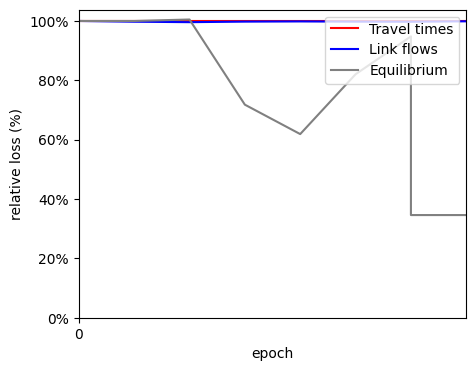

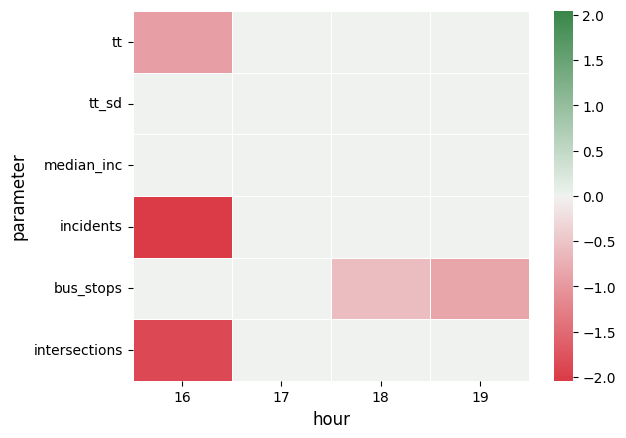

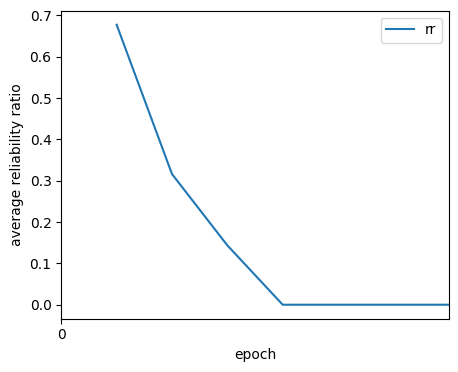

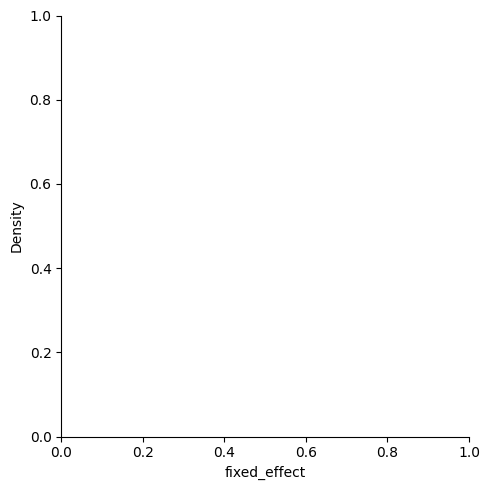

In [31]:
if run_model['lue']:
    print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

    # _MOMENTUM_EQUILIBRIUM = 1

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           # initial_values ={'tt': -1, 'tt_sd': -1, 'median_inc': 1,
                                           #                  'incidents': -1, 'bus_stops': -1, 'intersections': -1,
                                           #                  'psc_factor': 0, 'fixed_effect': np.zeros_like(fresno_network.links)},
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': _FIXED_EFFECT,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True, 'incidents': True,
                                                              'bus_stops': True, 'intersections': True
                                                       },
                                           time_varying = True
                                           )

    utility_parameters.constant_initializer(0)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=fresno_network,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       )

    lue = GISUELOGIT(
        key='lue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator = equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods = len(np.unique(X_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs['lue'], test_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        threshold_relative_gap=_RELATIVE_GAP,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['lue'],
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        loss_metric=_LOSS_METRIC,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    # Relative loss curves over epochs
    plot_predictive_performance(train_losses=train_results_dfs['lue'], val_losses=test_results_dfs['lue'],
                                xticks_spacing = _XTICKS_SPACING)

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(lue, df, period_feature='hour')

    # Reliability ratio over hours
    rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': 'hour', 0: 'rr'})
    sns.lineplot(data=rr_df, x='hour', y="rr")

    # Average reliability ratio over epochs
    plot_convergence_estimates(estimates=train_results_dfs['lue'].\
                       assign(rr = train_results_dfs['lue']['tt_sd']/train_results_dfs['lue']['tt'])[['epoch','rr']],
                           xticks_spacing = _XTICKS_SPACING)

    plt.ylabel('average reliability ratio')

    # Distribution of fixed effects
    sns.displot(pd.DataFrame({'fixed_effect':np.array(lue.fixed_effect)}),
        x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    #print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
    print(f"theta:\n\n\ {theta_df.assign(rr = theta_df['tt_sd']/theta_df['tt'])}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 2: OD + utility estimation with historic OD


ODLUE: OD + utility estimation with historic OD

Epoch: 0/6, n_periods: 4,  n_train: 60
0: train_loss=3.5e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.7e-31, lambda eq=1, relative x=2.1e-16, relative gap=1e-10, train flow equilibrium loss=1.3e-29, time: 0.5

Epoch: 1/6, n_periods: 4,  n_train: 60
1: train_loss=1.2e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [-0.213 -0.328  0.224 -0.224 -0.308 -0.219], avg rr = 1.54, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=2.9, lambda eq=0.34, relative x=0.49, relative gap=1.3e+02, train flow equilibrium loss=28, time: 1.1

Epoch: 2/6, n_periods: 4,  n_train: 60
2: train_loss=1.1e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss 

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_53195/589443703.py:92: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(pd.DataFrame({'fixed_effect':np.array(odlue.fixed_effect)}),


theta:

\             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
hour                                                                        
16    0.000000  0.000000    0.000000   0.000000        0.0       0.000000   
17   -2.283669 -1.744024    2.504724  -2.517377        0.0      -2.379404   
18    0.000000  0.000000    0.000000   0.000000        0.0       0.000000   
19    0.000000  0.000000    0.000000   0.000000        0.0       0.000000   

            rr  
hour            
16         NaN  
17    0.763694  
18         NaN  
19         NaN  
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  7.63
Avg observed OD:  6.32


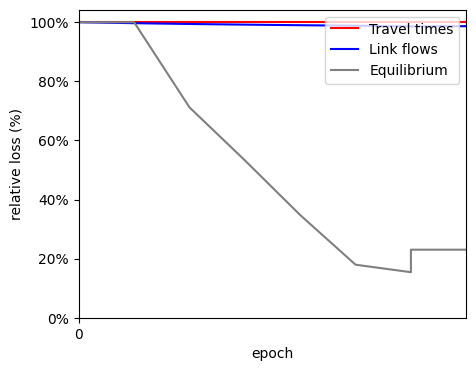

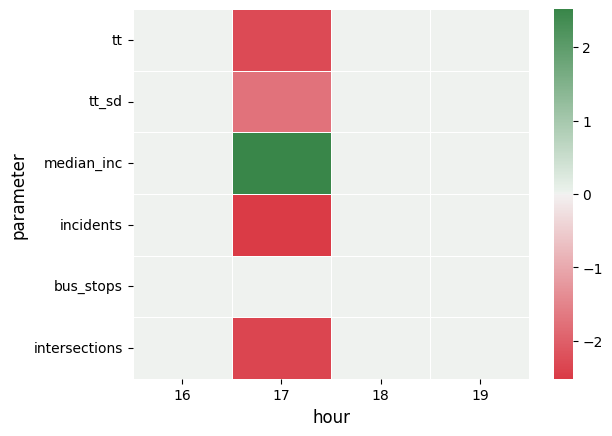

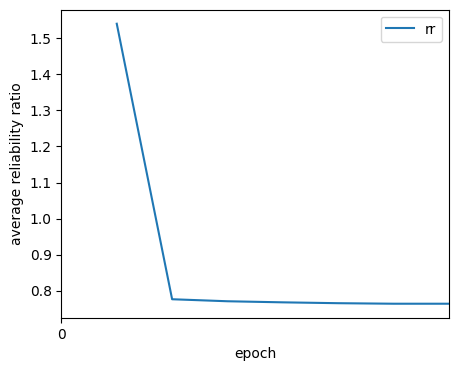

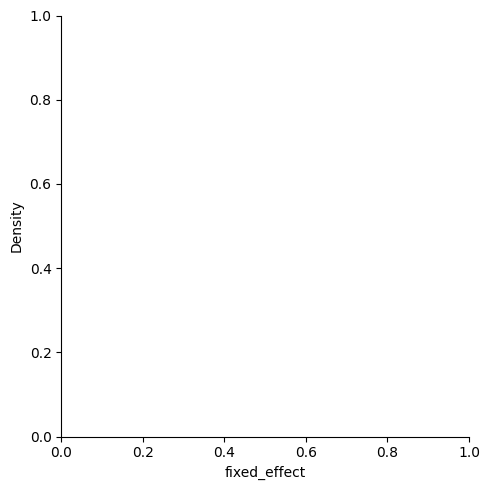

In [32]:
if run_model['odlue']:

    # _MOMENTUM_EQUILIBRIUM = 0.99

    print('\nODLUE: OD + utility estimation with historic OD')

    # _RELATIVE_GAP = 1e-4\
    # _XTICKS_SPACING = 50

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': _FIXED_EFFECT,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           time_varying = True
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlue = GISUELOGIT(
        key='odlue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods = len(np.unique(X_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs['odlue'], test_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlue'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlue'], val_losses=test_results_dfs['odlue'],
                                xticks_spacing = _XTICKS_SPACING)

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(odlue, df, period_feature='hour')

    rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': 'hour', 0: 'rr'})
    sns.lineplot(data=rr_df, x='hour', y="rr")

    plot_convergence_estimates(estimates=train_results_dfs['odlue'].\
                       assign(rr = train_results_dfs['odlue']['tt_sd']/train_results_dfs['odlue']['tt'])[['epoch','rr']],
                           xticks_spacing = _XTICKS_SPACING)
    plt.ylabel('average reliability ratio')

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    #print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}")
    print(f"theta:\n\n\ {theta_df.assign(rr = theta_df['tt_sd']/theta_df['tt'])}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: ODLUE + link specific performance parameters (alphas and betas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)

Epoch: 0/6, n_periods: 4,  n_train: 60
0: train_loss=3.5e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.7e-31, lambda eq=1, relative x=2.1e-16, relative gap=1e-10, train flow equilibrium loss=1.3e-29, time: 0.6

Epoch: 1/6, n_periods: 4,  n_train: 60
1: train_loss=1.1e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [-0.209 -0.338  0.224 -0.224 -0.219 -0.217], avg rr = 1.62, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2, lambda eq=0.34, relative x=0.48, relative gap=1.3e+02, train flow equilibrium loss=25, time: 1.3

Epoch: 2/6, n_periods: 4,  n_train: 60
2: train_loss=1.1e+06, val_loss=0, train_loss tt=3.8

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_53195/2825290873.py:112: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe.fixed_effect)}),


theta:

\             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
hour                                                                        
16    0.000000  0.000000    0.000000   0.000000        0.0       0.000000   
17    0.000000  0.000000    0.000000   0.000000        0.0       0.000000   
18   -2.127651 -1.292898    2.499446  -2.522724        0.0      -2.286773   
19    0.000000  0.000000    0.000000   0.000000        0.0       0.000000   

            rr  
hour            
16         NaN  
17         NaN  
18    0.607665  
19         NaN  
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  8.07
Avg observed OD:  6.32


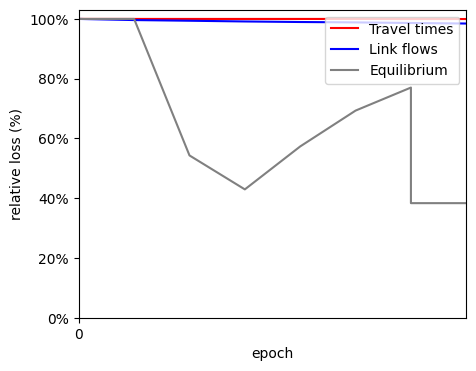

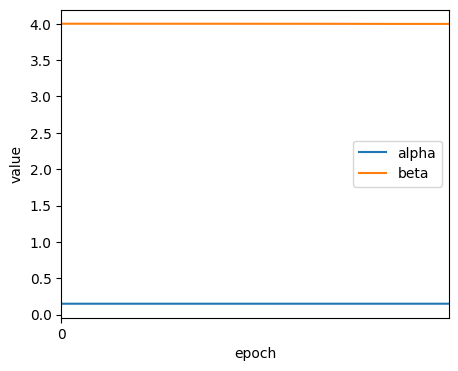

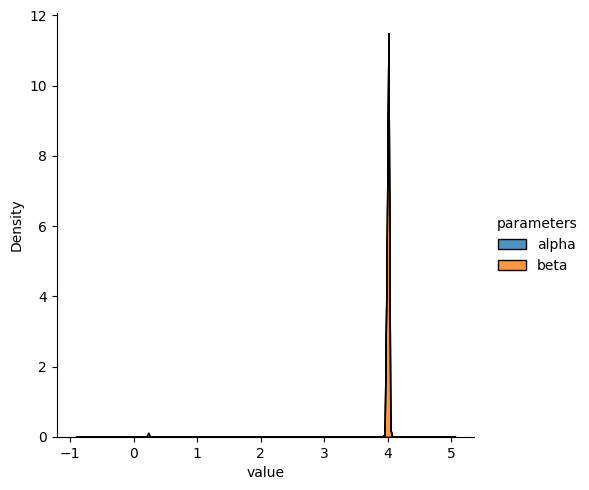

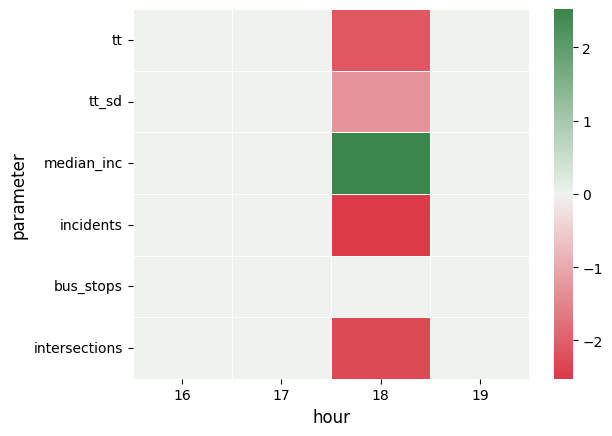

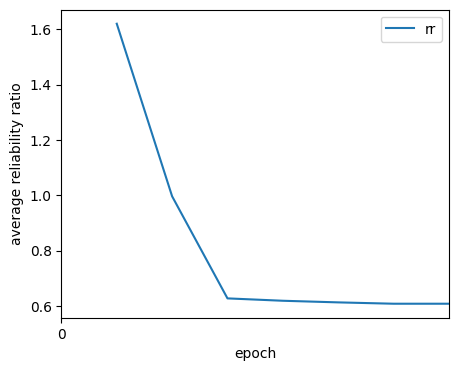

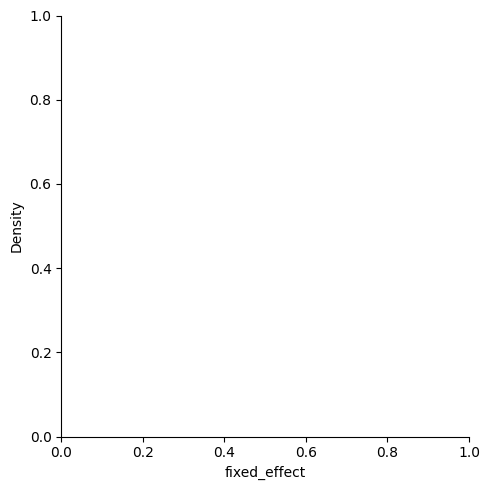

In [33]:
if run_model['odlulpe']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

    # _MOMENTUM_EQUILIBRIUM = 0.99

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 5e-1
    # _RELATIVE_GAP = 1e-5

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # trainables={'alpha': True, 'beta':False},
                                   trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True
                                 )

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': _FIXED_EFFECT,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           time_varying = True
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe = GISUELOGIT(
        key='odlulpe',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods = len(np.unique(X_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs['odlulpe'], test_results_dfs['odlulpe'] = odlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        # loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1},
        loss_weights=_LOSS_WEIGHTS,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlulpe'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        loss_metric=_LOSS_METRIC,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe'], val_losses=test_results_dfs['odlulpe'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe'][['epoch','alpha','beta']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':odlulpe.alpha, 'beta': odlulpe.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(odlulpe, df, period_feature='hour')

    rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': 'hour', 0: 'rr'})
    sns.lineplot(data=rr_df, x='hour', y="rr")

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe'].\
                   assign(rr = train_results_dfs['odlulpe']['tt_sd']/train_results_dfs['odlulpe']['tt'])[['epoch','rr']],
                       xticks_spacing = _XTICKS_SPACING)
    plt.ylabel('average reliability ratio')

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    #print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe.theta.numpy())))}")
    print(f"theta:\n\n\ {theta_df.assign(rr = theta_df['tt_sd']/theta_df['tt'])}")
    print(f"alpha = {np.mean(odlulpe.alpha): 0.2f}, beta  = {np.mean(odlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 4: TVODLULPE (ODLULPE with Time Varying OD and Utility Function)


tvodlulpe: Time specific utility and OD, link performance parameters, no historic OD

Epoch: 0/6, n_periods: 4,  n_train: 60
0: train_loss=3.5e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.7e-31, lambda eq=1, relative x=2.1e-16, relative gap=1e-10, train flow equilibrium loss=1.3e-29, time: 0.7

Epoch: 1/6, n_periods: 4,  n_train: 60
1: train_loss=1.1e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3, lambda eq=0.34, relative x=0.42, relative gap=0.045, train flow equilibrium loss=20, time: 1.3

Epoch: 2/6, n_periods: 4,  n_train: 60
2: train_loss=1.1e+06, val_loss=0, train_loss tt=3.8e-05, val_loss tt=0, train_loss flow=3.5e+06, v

KeyError: 'y'

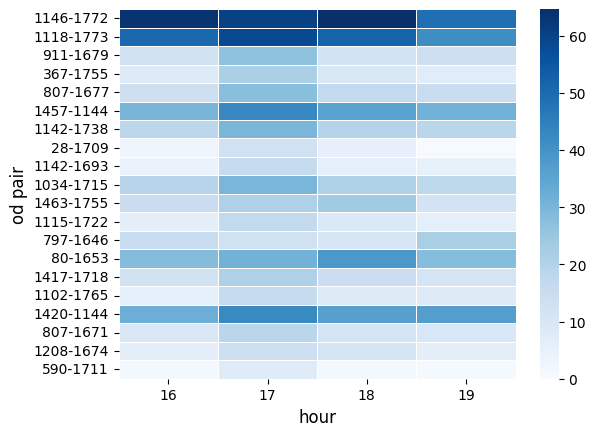

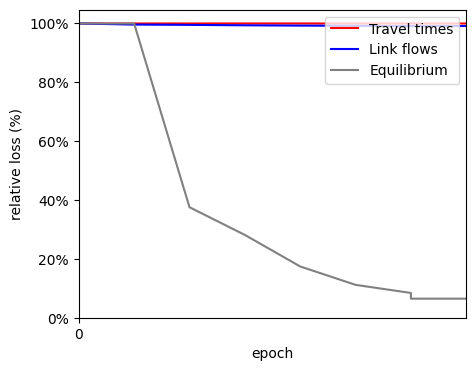

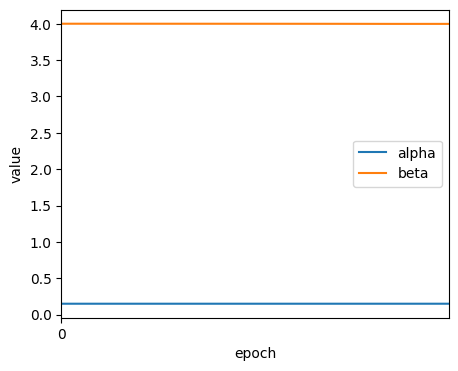

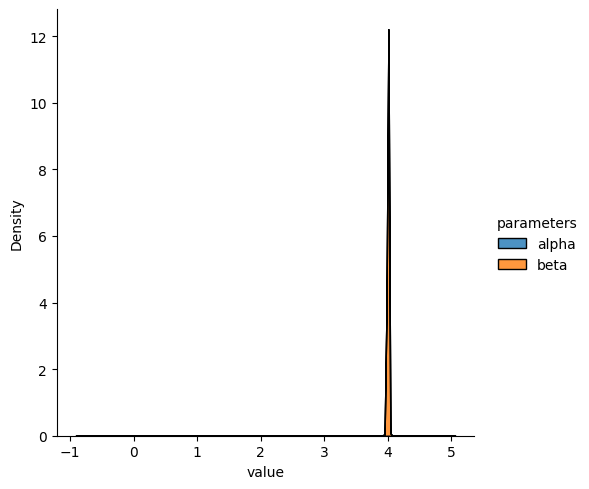

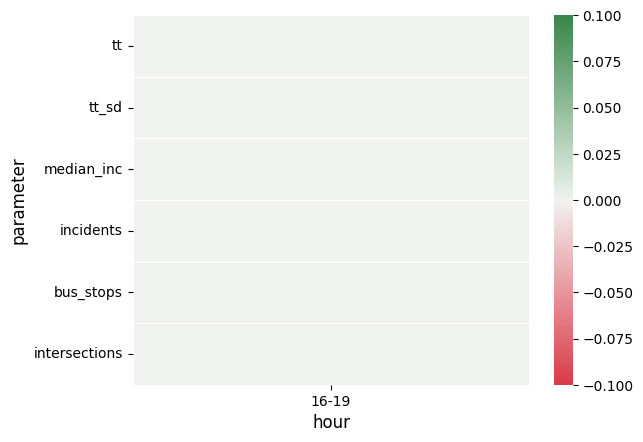

In [34]:
if run_model['tvodlulpe']:
    print('\ntvodlulpe: Time specific utility and OD, link performance parameters, no historic OD')

    # Only in this model, we can add fixed effect and have identifiable utility function coefficients

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': _FIXED_EFFECT},
                                           time_varying=False,
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   trainables={'alpha': True, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 time_varying=True,
                                 trainable=True)

    tvodlulpe = GISUELOGIT(
        key='tvodlulpe',
        network=fresno_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods = len(np.unique(XT_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs['tvodlulpe'], test_results_dfs['tvodlulpe'] = tvodlulpe.train(
        XT_train, YT_train, XT_test, YT_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium=_MOMENTUM_EQUILIBRIUM['tvodlulpe'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs=_EPOCHS)

    # Plot heatmap with flows of top od pairs
    plot_top_od_flows_periods(tvodlulpe, df, period_feature='hour', top_k=20)

    plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=test_results_dfs['tvodlulpe'],
                               xticks_spacing=_XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=_XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':tvodlulpe.alpha, 'beta': tvodlulpe.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(tvodlulpe, df, period_feature='hour')

    rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': 'hour', 0: 'rr'})
    sns.lineplot(data=rr_df, x='hour', y="rr")

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'].\
               assign(rr = train_results_dfs['tvodlulpe']['tt_sd']/train_results_dfs['tvodlulpe']['tt'])[['epoch','rr']],
                   xticks_spacing = _XTICKS_SPACING)
    plt.ylabel('average reliability ratio')

    sns.displot(pd.DataFrame({'fixed_effect': np.array(tvodlulpe.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha=0.8)

    # print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(tvodlulpe.theta.numpy())))}")
    print(f"theta:\n\n\ {theta_df.assign(rr = theta_df['tt_sd']/theta_df['tt'])}")
    print(f"alpha = {np.mean(tvodlulpe.alpha): 0.2f}, beta  = {np.mean(tvodlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(tvodlulpe.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

## Write csv file with estimation results

In [ ]:
train_results_df, test_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, test_results_dfs])

network_name = 'Fresno'

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
test_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
test_results_df.to_csv(f"./output/tables/{test_filename}")
print(f'File {test_filename} was written')

## Summary of models parameters

In [ ]:
models = [lue,odlue,odlulpe, tvodlulpe]
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models:
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z +
                      ['rr'] +
                      ['fixed_effect_mean', 'fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       'od_mean', 'od_std',],
         'values': list(np.mean(model.theta.numpy(),axis =0))  +
                   [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
                   [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                    np.mean(model.alpha),np.std(model.alpha),
                    np.mean(model.beta),np.std(model.beta),
                    np.mean(model.q),np.std(model.q)]}).\
                             assign(model = model.key)
                             )

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_tt', 'loss_eq_flow', 'loss_total']

for i, model in enumerate(models):

    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model = model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = results_losses.append(results_losses_model)

results_losses[loss_columns] = (results_losses[loss_columns]-1)*100

## Plot of convergence toward true rr across models

In [ ]:
models = [lue,odlue,odlulpe, tvodlulpe]

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.set_ylabel('reliability ratio')

plt.ylim(ymin=0)

plt.show()